## Base model construction and training
This notebook includes importing and unpacking data that have been preprocessed for model training and training a single CNN model. Additional models or model adjustments - including exposure to augmented training data - will be performed in separate notebooks.

Spectrograms have already been **standardized** (standard-scaler within each array, not across whole dataset), **reshaped**, and train-test-splat in prior notebook. This format is due to memory limitations: training the model on all data at once continuosly broke.  As such, I have broken the whole into 9 chunks and will train the model(s) with each subset sequentially. Train-test subsets will be deleted before importing the next one to free up as much memory as possible. Overkill? Yes. But better than a dead kernel partway through fitting. The code below begins with importing the subsets, already standardized, already divided into train-test splits with consistent pos:neg ratios. Import formats are lists of tuples: (spectrogram_array , label).  

The architecture for this base model is based on that of deep learning networks used for marine mammal acoustics in several sources. These sources were operating with data of different volumes, from different environments, and often to different ends (ie multiclass classification, or dealing with species functioning in entirely different frequency ranges). Thus, no network from prior literature is ready 'out of the box' for this project, but they are a better starting point than completely winging it.

EDIT: kernel still dies upon fitting second or third subset. Reducing model complexity to run to completion here, but with heavily downsampled data _and_ shallow network, impressive results not expected. See results from AWS for results on higher resolution data.

---
#### Spoiler Results
Reducing model complexity and subsetting data freed up enough memory to return to using the higher resolution spectrograms, but still no convergence. I will continue tuning this shallow network and push results if they are compelling, but the main course of action needed is deepening the network beyond my local machine's capability. External servers being pursued.

---
Sources guiding CNN structure:  
* [Padovese et al. 2021.](https://asa.scitation.org/doi/full/10.1121/10.0004258) Data augmentation for the classification of North Atlantic right whales upcalls. _Journal of the Acoustical Society of America_ 149:4.
* [Thomas et al. 2019.](https://ecmlpkdd2019.org/downloads/paper/314.pdf) Marine Mammal Species Classification using CNN and a Novel Acoustic Representation. 
* [Shiu et al. 2020.](https://www.nature.com/articles/s41598-020-57549-y) Deep neural networks for automated detection of marine mammal species. _Nature: Scientific Reports_ 10:607.
* I did not look up correct citation format, please send all complaints to https://github.com/charles-rice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, \
                            accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

import random
random.seed(42)

In [2]:
#import data, assign pos/neg
in_path = '../scratch_data/tts_chunked/'
files = os.listdir(in_path)
files

['ch5_test.pkl',
 'ch4_test.pkl',
 'ch7_train.pkl',
 'ch1_train.pkl',
 'ch6_train.pkl',
 'ch8_test.pkl',
 'ch2_test.pkl',
 'ch3_test.pkl',
 'ch0_train.pkl',
 'ch8_train.pkl',
 'ch5_train.pkl',
 'ch6_test.pkl',
 'ch7_test.pkl',
 'ch3_train.pkl',
 'ch1_test.pkl',
 'ch0_test.pkl',
 'ch4_train.pkl',
 'ch2_train.pkl']

In [3]:
with open (in_path+'ch0_train.pkl', mode = 'rb') as f:
    ch0_train = pickle.load(f)
with open (in_path+'ch0_test.pkl', mode = 'rb') as j:
    ch0_test = pickle.load(j)

In [4]:
X_train0, y_train0 = list(zip(*ch0_train))
X_train0 = np.array(X_train0)
y_train0 = np.array(y_train0)
print(type(X_train0), X_train0.shape)
print(type(y_train0), y_train0.shape)

<class 'numpy.ndarray'> (1875, 610, 368, 1)
<class 'numpy.ndarray'> (1875,)


In [5]:
X_test0, y_test0 = list(zip(*ch0_test))
X_test0 = np.array(X_test0)
y_test0 = np.array(y_test0)
print(type(X_test0), X_test0.shape)
print(type(y_test0), y_test0.shape)

<class 'numpy.ndarray'> (625, 610, 368, 1)
<class 'numpy.ndarray'> (625,)


In [6]:
print(pd.Series(y_train0).value_counts(normalize=True))
print(pd.Series(y_test0).value_counts(normalize=True))

0    0.749867
1    0.250133
dtype: float64
0    0.7504
1    0.2496
dtype: float64


#### Model architecture
Basic LeNet construction, preceded by a Conv2D layer with a larger filter and stride to reduce dimensions quickly.

In [7]:
# 3 x convolutional layers with max pooling
cnn = Sequential()
cnn.add(Conv2D(filters = 8, 
               kernel_size=(11,11),
               strides = (4,4), #kernel_size and stride from AlexNet
               activation='relu', 
               input_shape=(610, 368, 1),
               padding = 'valid')) #no padding
cnn.add(MaxPooling2D(pool_size = (3,3), strides=(2,2)))
#cnn.add(BatchNormalization())

cnn.add(Conv2D(filters= 16, 
              kernel_size=(5,5), #LeNet uses 2xconv2d with 5x5 kernel, 2x2 pooling
              activation='relu')) #default strides =1
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
        
cnn.add(Conv2D(filters = 16,
               kernel_size = (5,5),
               activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))  #output dim = 15 x 8 x 16 = 1920

cnn.add(Flatten())

# 2 x hidden layers w dropout and weight decay
#input nodes = # features
cnn.add(Dense(1920, activation='relu', kernel_regularizer=l2(.001))) 
cnn.add(Dropout(.2)) #double regularization to mitigate overfitting
cnn.add(Dense(128, activation = 'relu', kernel_regularizer=l2(.001)))
cnn.add(Dropout(.2))
cnn.add(Dense(1, activation='sigmoid')) #output layer binary classification

In [8]:
# compile model
cnn.compile(loss = 'binary_crossentropy', optimizer='Adam', 
            metrics=['acc', 'Recall', 'Precision'])

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 90, 8)        976       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 44, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 40, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 20, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 16, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 8, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0

In [10]:
#add earlystop?
early_stop = EarlyStopping(patience = 10)

#### Fit model
Verbose at first bc the feedback is helpful to know if things are progressing. Not enacting early_stop because want model trained on all subsets equally. Small batches seems to help with memory demands.

In [11]:
history = cnn.fit(X_train0, y_train0,
                  batch_size=64,
                  validation_data = (X_test0, y_test0),
                  epochs = 300,
                  callbacks=early_stop)

Epoch 1/300
30/30 [==============================] - 18s 575ms/step - loss: 2.8272 - acc: 0.7217 - recall: 0.0227 - precision: 0.0915 - val_loss: 2.7529 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/300
30/30 [==============================] - 17s 571ms/step - loss: 2.7703 - acc: 0.7451 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 2.7529 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/300
30/30 [==============================] - 17s 562ms/step - loss: 2.7606 - acc: 0.7386 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 2.7529 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/300
30/30 [==============================] - 17s 567ms/step - loss: 2.7471 - acc: 0.7613 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 2.7529 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/300
30/30 [==============================] - 17s 574ms/step - loss: 2.76

In [12]:
del X_train0, y_train0, X_test0, y_test0
gc.collect()

1648

One subset success without memory overload. Just predicting majority class the whole time - no surprise it couldn't pull nuances out of such small subset, check back at the end.  Looping the rest, verbose=0.

In [13]:
#function to speed up future chunks

def pkl_to_CNN(train_file, test_file):
    with open (in_path+train_file, mode = 'rb') as f:
        temp_train = pickle.load(f)
    with open (in_path+test_file, mode = 'rb') as j:
        temp_test = pickle.load(j)
        
    X_train, y_train = list(zip(*temp_train))
    X_test, y_test = list(zip(*temp_test))

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [14]:
histlist = []
histlist.append(history.history)

In [15]:
for i in range(1,9):
    
    X_train, X_test, y_train, y_test = pkl_to_CNN(f'ch{i}_train.pkl', f'ch{i}_test.pkl')

    history = cnn.fit(X_train, y_train,
                      batch_size=64,
                      validation_data = (X_test, y_test),
                      epochs = 300, 
                      callbacks = early_stop, verbose=0)
    histlist.append(history.history)
    print(f'chunk {i} of 8 fit')

chunk 1 of 8 fit
chunk 2 of 8 fit
chunk 3 of 8 fit
chunk 4 of 8 fit
chunk 5 of 8 fit
chunk 6 of 8 fit
chunk 7 of 8 fit
chunk 8 of 8 fit


In [20]:
#eval on unseen test set to follow, but score for last chunk trained:
#predicted majority class the whole time, no convergence, HUGE loss holy heck
cnn_score = cnn.evaluate(X_test, y_test, verbose=1)

19/19 [==============================] - 0s 24ms/step - loss: 733.9913 - acc: 0.7504 - recall: 0.0000e+00 - precision: 0.0000e+00


In [53]:
len(histlist[8]['loss'])

21

#### Retrain on the same data
Rationale: when early_stop is implemented, the model does not see each input the same number of times. For instance, the first subset above early_stopped at 11 epochs, while the last ran for 21 epochs. So with early stopping, this is not a direct parallel to providing a singular dataset of size 22,000.  However, setting fixed epochs (100) on such small subsets also led to failure to converge. Bit of a shot in the dark, but considering nothing has converged so far with this chunky format, why not try refitting on the same subsets _again_ to see if there is newly discernible information in the earlier subsets that is only apparent now that it's seen the whole. Why not?  
Well, data leakage is why not: the model has now 'seen' the every test subset before so this is bad practice if these are your final scores. However, it has yet to be exposed to a separate holdout set, so it can still be validated. 

---
Results: still no better than baseline. A couple visualizations of the loss (below) look more like what we want to see - converging over time, train/test loss in unison. But this only confirms data leakage and doesn't even hold for subsequent training.

In [24]:
for i in range(0,9):
    
    X_train, X_test, y_train, y_test = pkl_to_CNN(f'ch{i}_train.pkl', f'ch{i}_test.pkl')

    history = cnn.fit(X_train, y_train,
                      batch_size=64,
                      validation_data = (X_test, y_test),
                      epochs = 300, 
                      callbacks = early_stop, verbose=0)
    histlist.append(history.history)
    print(f'chunk {i+1} of 9 fit')

chunk 1 of 9 fit
chunk 2 of 9 fit
chunk 3 of 9 fit
chunk 4 of 9 fit
chunk 5 of 9 fit
chunk 6 of 9 fit
chunk 7 of 9 fit
chunk 8 of 9 fit
chunk 9 of 9 fit


In [34]:
cnn_labels = cnn.metrics_names
for i in range(len(cnn_labels)):
    print(f'CNN final subset {cnn_labels[i]} : {cnn_score[i]}')
# print(f'CNN last chunk {cnn_labels})

CNN final subset loss : 0.5619027018547058
CNN final subset acc : 0.7504244446754456
CNN final subset recall : 0.0
CNN final subset precision : 0.0


#### Visualize

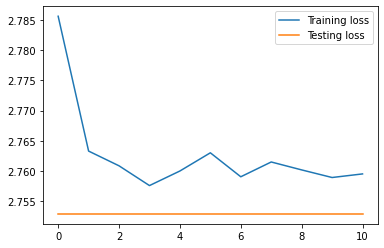

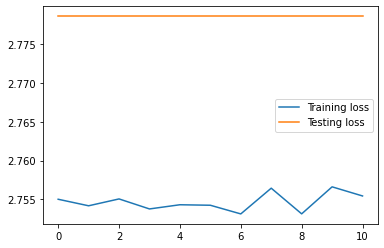

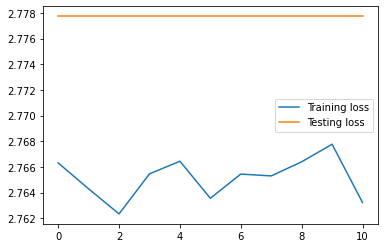

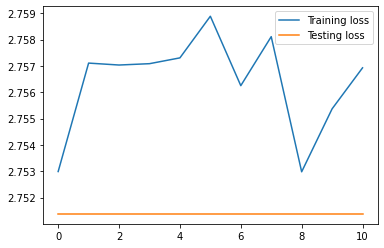

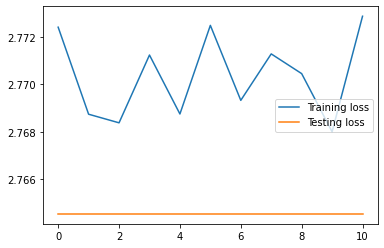

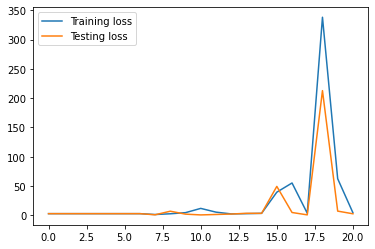

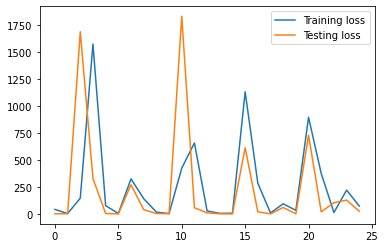

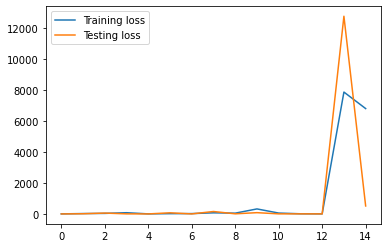

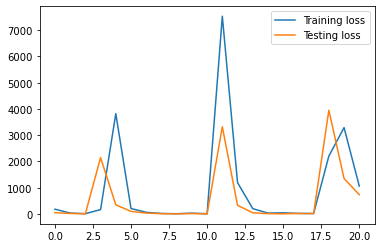

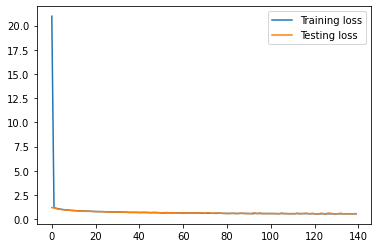

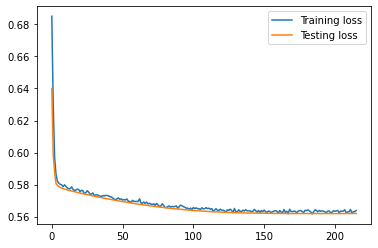

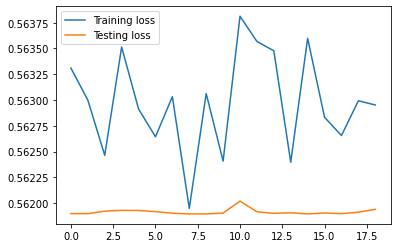

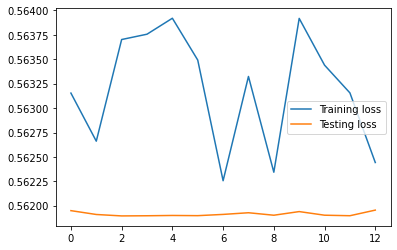

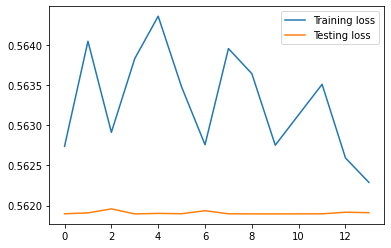

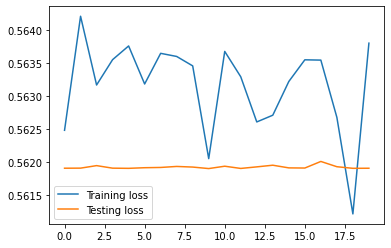

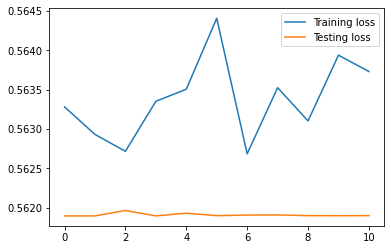

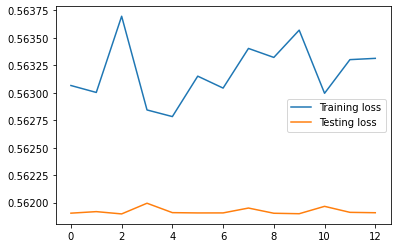

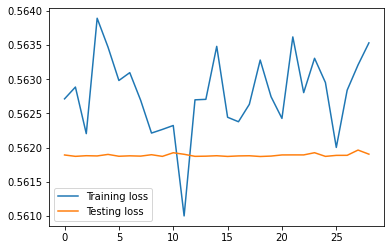

In [50]:
for i in range(len(histlist)):
    plt.figure()
    plt.plot(histlist[i]['loss'], label='Training loss')
    plt.plot(histlist[i]['val_loss'], label='Testing loss')
    plt.legend();

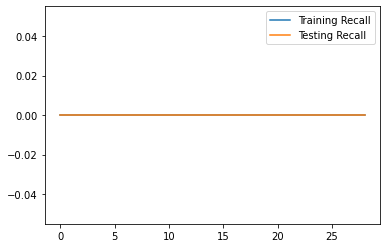

In [27]:
#priority metric = recall: minimize false negatives
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Testing Recall')
plt.legend();

In [28]:
with open ('../data/models/02_hist_cnn_base.pkl', mode = 'wb') as f:
    pickle.dump(histlist, f)

In [46]:
import tensorflow
tensorflow.keras.models.save_model(cnn, '../data/models/02_lg_dnc')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ../data/models/02_lg_dnc/assets


### Next Steps
Realistically, this neural net needs to be deeper. In literature review, the only models with any level of success utilize many more layers OR **many** more filters, or both. I will refit with tweaked versions of the above independently and report if there is any success with that approach (such as adjusting regularization, customizing patience per subset, minor adjustments to filters and nodes). However, the main gains will be through increased computing power that allow me to deepend the neural network beyond those minor tunings. External server options are being pursued. Stay tuned.